In [34]:
import pandas as pd # Data Manipulation 
import numpy as np # Numerical representation and calculation 
import os # accessing where files are located 
from IPython.display import Image # For image processing 
import missingno as msno # Plot representation of levels of missing values and their verbidung .
from sklearn.impute import KNNImputer # To take care of missing values 
from numpy import nan # filling in null values with 0 where necessary 
import re # Takes care of regular expressions .
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns

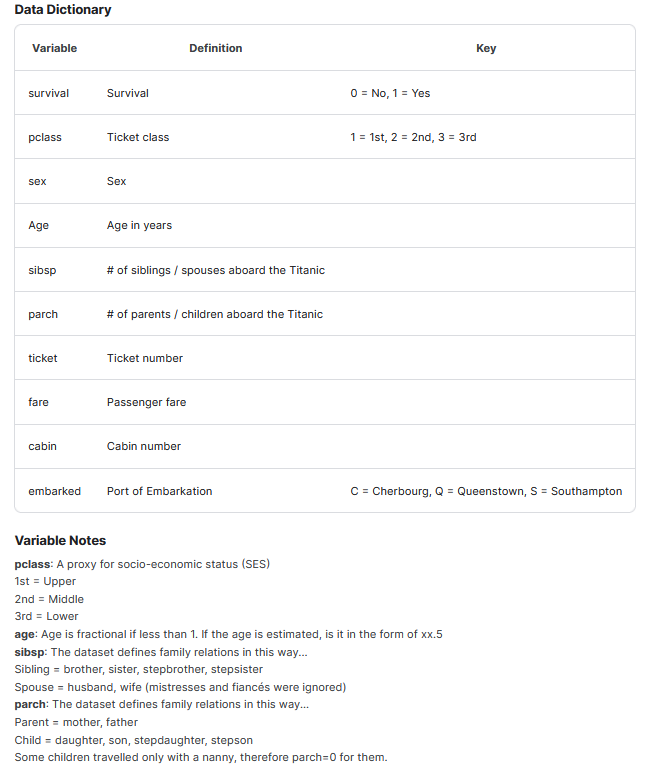

In [2]:
# get the image 
url = r"C:\ML Assignments\Kaggle\Titanic_Project\Data_description.png"
Image(url,width = 700 ,height= 700)

In [3]:
def find_csv_files(path):
    csv_files = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if name.endswith((".csv", ".csv")):
                csv_files.append(os.path.join(root, name))
    return csv_files

In [4]:
folder_path = "C:\ML Assignments\Kaggle\Titanic_Project"
csv_files_list = find_csv_files(folder_path)
for file_path in csv_files_list:
    print(file_path)

C:\ML Assignments\Kaggle\Titanic_Project\test.csv
C:\ML Assignments\Kaggle\Titanic_Project\train.csv


In [5]:
train_dataset = pd.read_csv(r"C:\ML Assignments\Kaggle\Titanic_Project\train.csv")
train_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Investigating Missing values per column in the training data set. 

<Axes: >

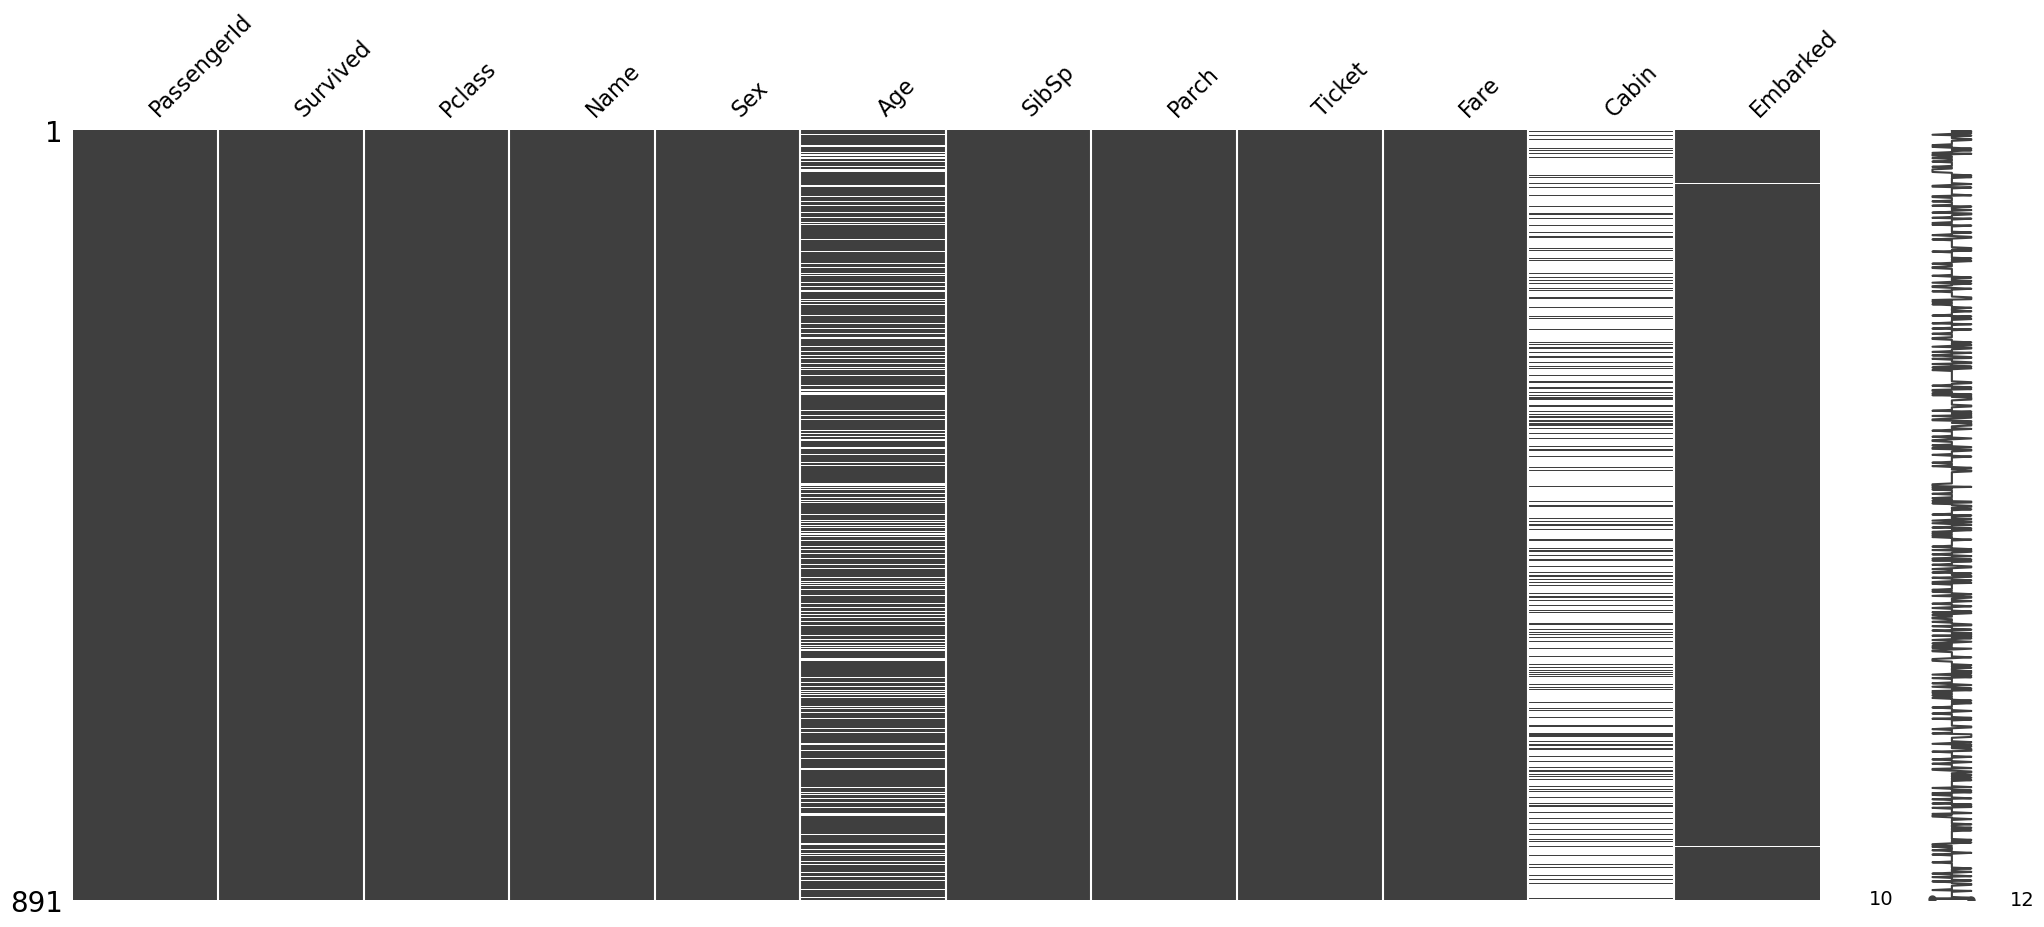

In [6]:
msno.matrix(train_dataset)
# we can see that cabin has the highest number of missing columns 

<Axes: >

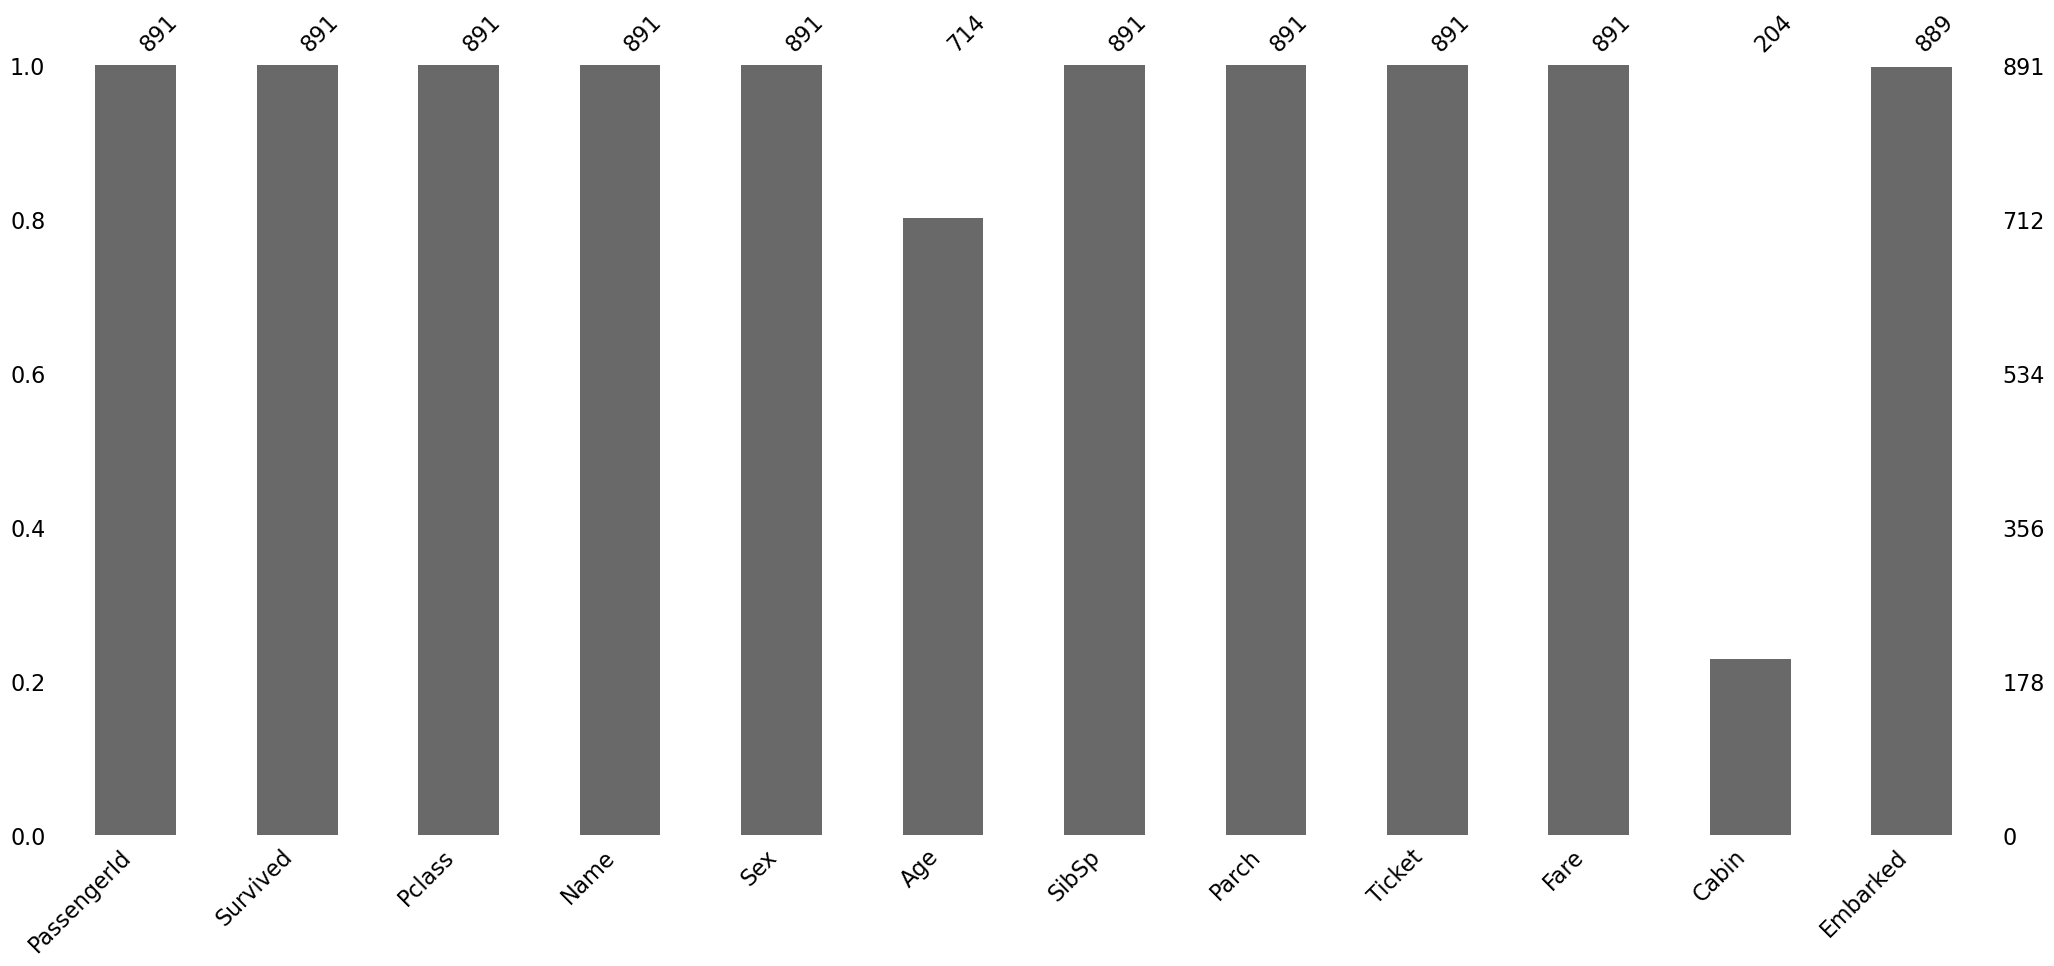

In [7]:
msno.bar(train_dataset)

The matrix above shows how many existing rows are found per column . We can see that Cabin has only 204 filled rows while age has 714 rows available . 

### Heat Map 
The heatmap is going to be used to understand correlation of missigness between various columns. A postive value shows or indicates a positive correlation between the missigness of two columns , and vice versa . **A concept known as Nulity Correlation** . `´It is important to also understand that this correlation is between those columns with missing data , those without are not in the case included`´

<Axes: >

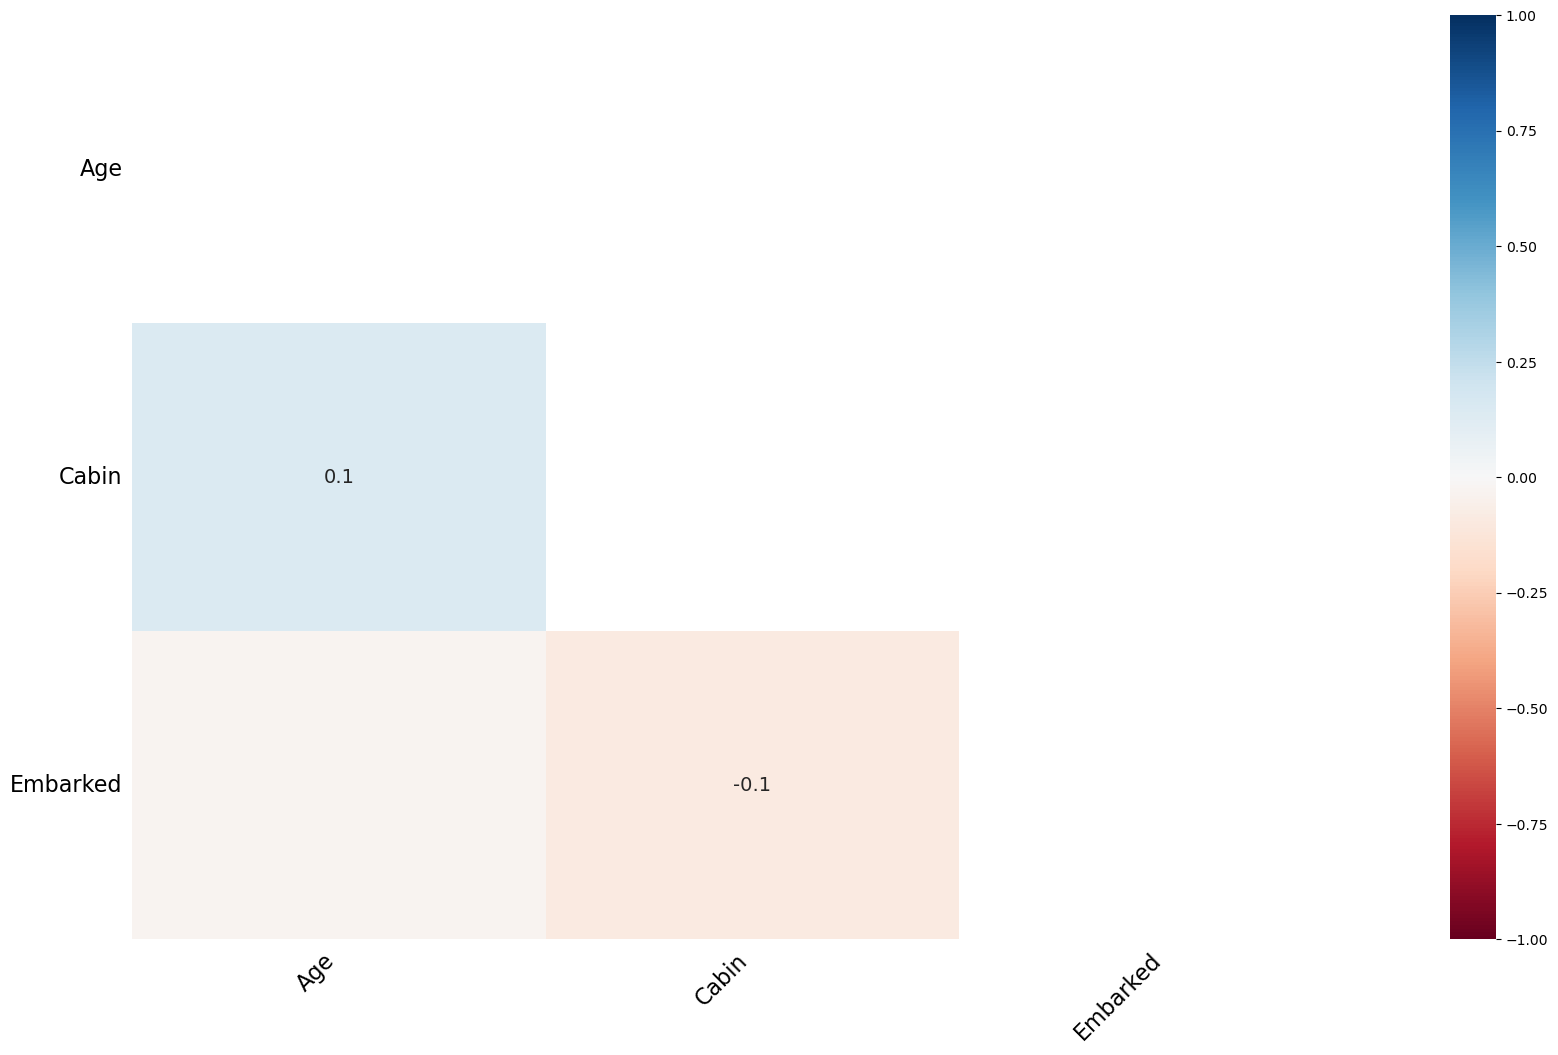

In [8]:
msno.heatmap(train_dataset)

## Dendrogram 
- A dendrogram  is a hierachical tree diagram that shows the arrangment of data points based on their similarity . In the context of missing data , a dendrogram can help visualize the relationship between columns ( features ) in terms of their missing values . 

<Axes: >

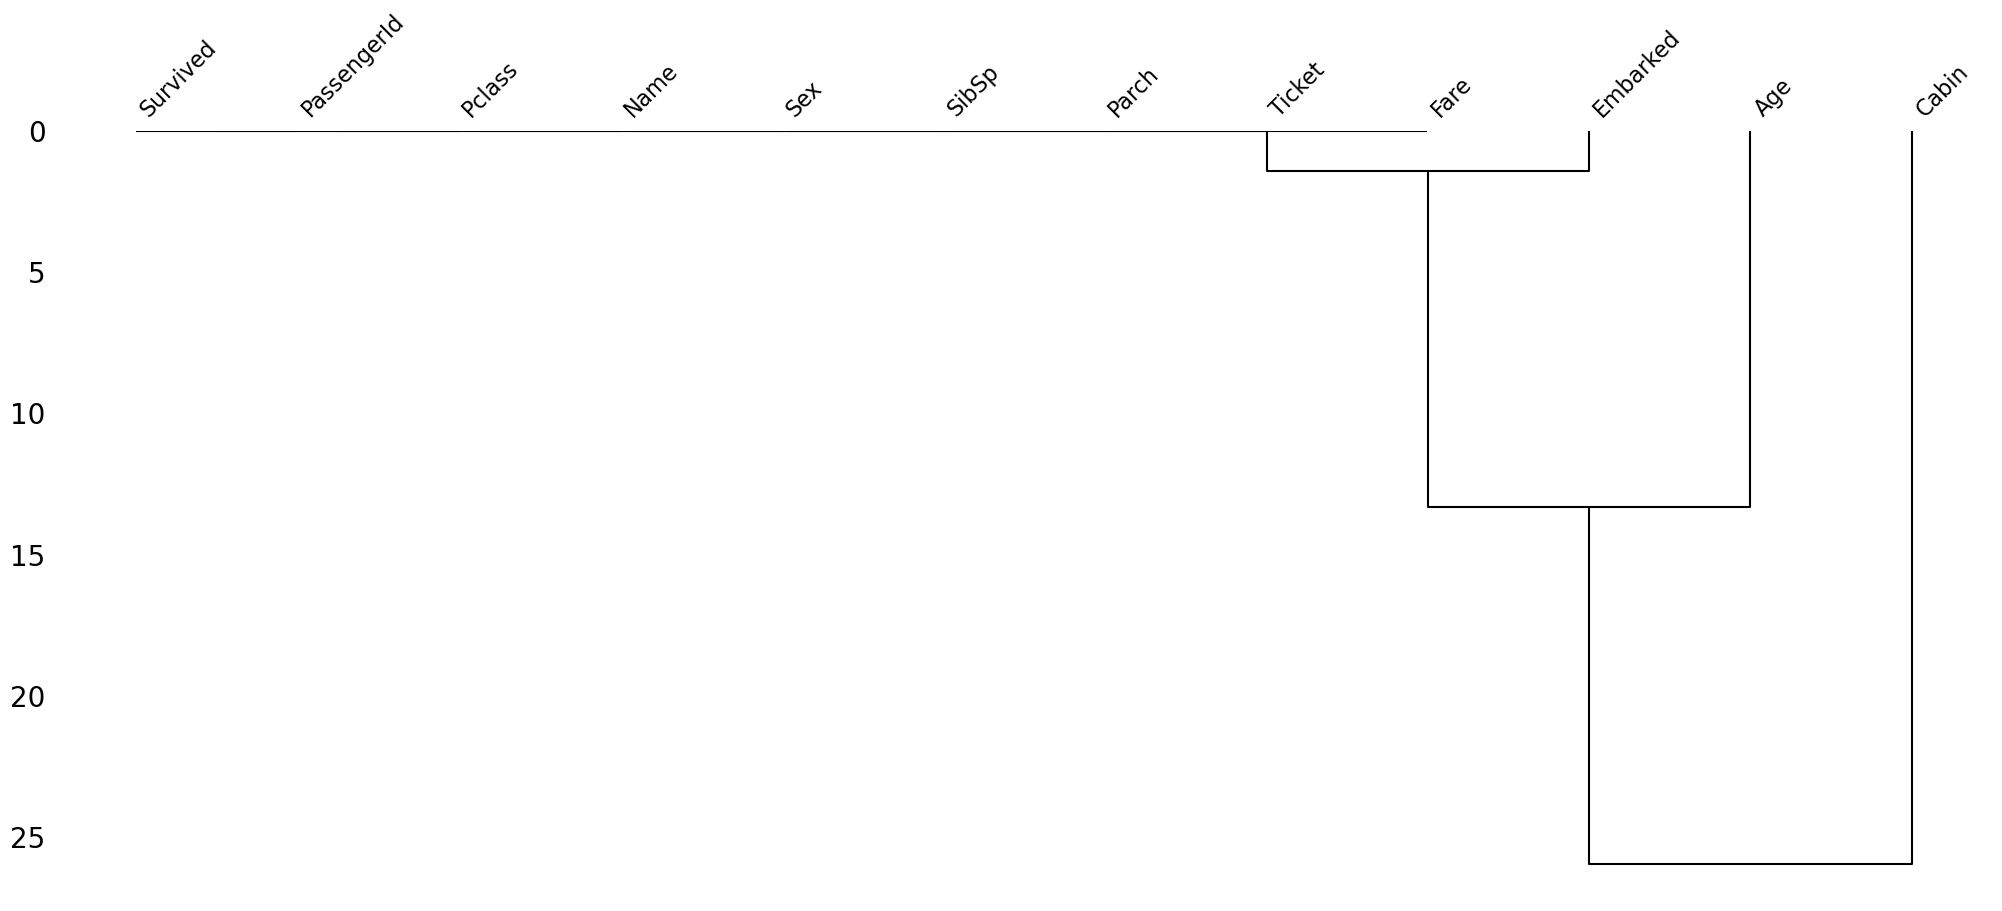

In [9]:
msno.dendrogram(train_dataset)

The highder the vertical line between the columns , the higher the disimilarity . That means that **Cabin and Age are not similar at all to each** and more **disimilar as compard to age and Fare** . 

### Investigating the Features
- It is is importnt to observe existing features and decide on whether it is worth it to retain them or not . 

In [10]:
def intitial_eda_checks(df):
    '''
    This function inspects columns with missing values and produces the total sum of the missing values as well as the 
    their corresponding percentages . In this way , I will be able to remove columns with significantly missing values . 
    
    Data impuation could be applied in this case but that will require further data manipulation to decide on whether it
    it a lasting solution . 
    '''
    if df.isnull().sum().sum() > 0:
        mask_total = df.isnull().sum().sort_values(ascending=False)
        total = mask_total[mask_total > 0]

        mask_percent = df.isnull().mean().sort_values(ascending=False)
        percent = mask_percent[mask_percent > 0]

        missing_data = pd.concat([total, percent],
                                 axis=1,
                                 keys=['Total', 'Percent'])

        print(f'Total and Percentage of NaN:\n {missing_data}')
    else:
        print('No NaN found.')

In [11]:
intitial_eda_checks(train_dataset)

Total and Percentage of NaN:
           Total   Percent
Cabin       687  0.771044
Age         177  0.198653
Embarked      2  0.002245


In [12]:
train_dataset.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

The result above indicate the the cabin feature has indeed more than 76% of missing rows , In order to prevent adding noise into the data set , it is statisticaly better to eliminate the column completely . This means that dropping all corresponding missing rows will largely affect the input data given only a small amoung of information will be left. For that matter **Dropping this specific column in order to spare the other rows is a much appropriate option**

In [13]:
def delete_unimportant_features(df, feature_one, feature_two, feature_three):
    '''
    This function takes in a DataFrame and removes specified columns that are not important for deciding
    a client's ability to receive credit. columns such as Names, customer_ID etc., do not play a part. 
    Users can specify additional features to drop out , more features to be removed will be taken care as time goes
    and this is very important for both of us . 
    '''
    df = df.drop(columns=[
        feature_one, feature_two,feature_three
    ],
                 inplace=True)
    return df

In [14]:
# Applying the delete_unimportant_features function to elimiate Names , PassangerID and
delete_unimportant_features(train_dataset,'Name','Cabin','PassengerId')

In [15]:
train_dataset.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Embarked'],
      dtype='object')

### Imputing Missing Values 
- I will first use the **KNN Imputer** this technique identifies the K closest points under a chosen distance metric (Euclidean by default). The number of closest points or neighbors is specified by the n_neighbors parameter. By default, the 5 closest neighbors are considered(machinelearningmastery.com)

In [16]:
# Applying the sklearn imputing method 
imputer = KNNImputer(n_neighbors=4)

# Retrieve the 'Age' column values
values = train_dataset['Age'].values
values_reshaped = values.reshape(-1, 1)

# Transform the dataset (impute missing values)
train_dataset['Age'] = imputer.fit_transform(values_reshaped).astype(int)

In [17]:
intitial_eda_checks(train_dataset)

Total and Percentage of NaN:
           Total   Percent
Embarked      2  0.002245


Because the missing values in the Embark is only 2 , this is techincally only a 0.002% meaning removing these two columns rows will not have a large effect on our machine learning model.
- I will furher on compare to see weather we have any differences or imporvement in the model when we rathe rapply imputation than simply removing the values . 

In [18]:
train_dataset.dropna(inplace = True)

In [19]:
train_dataset

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,male,22,1,0,A/5 21171,7.2500,S
1,1,1,female,38,1,0,PC 17599,71.2833,C
2,1,3,female,26,0,0,STON/O2. 3101282,7.9250,S
3,1,1,female,35,1,0,113803,53.1000,S
4,0,3,male,35,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27,0,0,211536,13.0000,S
887,1,1,female,19,0,0,112053,30.0000,S
888,0,3,female,29,1,2,W./C. 6607,23.4500,S
889,1,1,male,26,0,0,111369,30.0000,C


### Investigating on whether we have any duplicates in the ticket system
- This section looks at combination of features to remove any duplicates in the data set . In our case, upon further investigation , I have come to conclude on two things . 
- 1:Some tickets have been duplicated , how they do share the same **Ebarked** as in the starting point , this could mean that this family is most likely to be together . 
- 2:This is further argued in the direction of the **passanger class** given it is the same. 

In [20]:
Parch_ticket = train_dataset[['Parch','Ticket','SibSp','Embarked','Pclass','Sex']]
Parch_ticket_parent_greater_than1 = Parch_ticket[Parch_ticket["Parch"]>1]
Parch_ticket_parent_greater_than1

,Parch,Ticket,SibSp,Embarked,Pclass,Sex
8,2,347742,0,S,3,female
13,5,347082,1,S,3,male
25,5,347077,1,S,3,female
27,2,19950,3,S,1,male
43,2,SC/Paris 2123,1,C,2,female
...,...,...,...,...,...,...
850,2,347082,4,S,3,male
858,3,2666,0,C,3,female
863,2,CA. 2343,8,S,3,female
885,5,382652,0,Q,3,female


In [21]:
# Checking the duplicates in the form of Ticket , Embarked , Pclass and Sex
duplicateRows = train_dataset[train_dataset.duplicated(['Ticket'])]
duplicateRows.sort_values(by = 'Ticket').tail(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
120,0,2,male,21,2,0,S.O.C. 14879,73.5000,S
385,0,2,male,18,0,0,S.O.C. 14879,73.5000,S
685,0,2,male,25,1,2,SC/Paris 2123,41.5792,C
608,1,2,female,22,1,2,SC/Paris 2123,41.5792,C
403,0,3,male,28,1,0,STON/O2. 3101279,15.8500,S
888,0,3,female,29,1,2,W./C. 6607,23.4500,S
736,0,3,female,48,1,3,W./C. 6608,34.3750,S
436,0,3,female,21,2,2,W./C. 6608,34.3750,S
147,0,3,female,9,2,2,W./C. 6608,34.3750,S
745,0,1,male,70,1,1,WE/P 5735,71.0000,S


In [22]:
def remove_text (column):
    result = ''.join(re.findall(r'\d+', column)) 
    '''
     # This function is used to join strings together , ''.join('Make','Money') = (Make Money)
    '''
    if result == '':
        return '0'
    else : 
        return result 

In [23]:
# Applying the created function .
train_dataset['Ticket'] = train_dataset['Ticket'].apply(remove_text).astype(int)

We have anothe Important category called Sex which represents the the gender of a person . In this case, because the natural of the data is ordinal i.e It has a natural relation, it is best fit to apply the famous **oneHotEncoder offered by the Sklearn environemnt** . This removes any level of hierrachy from the data ensuring that the ML deals with it from a **natural ground**

In [24]:
def one_encode_Sex(df, column_name):
    # Initialize the encoder
    encoder = OrdinalEncoder()

    # Fit and transform the data; this does not happen in-place
    encoded_data = encoder.fit_transform(df[[column_name]])

    # Assign the encoded data back to the DataFrame in the specified column
    df[column_name] = encoded_data.astype(int)

In [25]:
# Appling the one_encode_Sex method . 
one_encode_Sex(train_dataset, 'Embarked')

In [26]:
def hotencoding (df,column_name):
    '''
    This function takes in a column and hot encodes into numerically into categorical columns.
    '''
    return  pd.get_dummies(train_dataset, columns = [column_name]).astype(int)

In [30]:
train_dataset = hotencoding(train_dataset, 'Sex')

### Feature Selection
- Feature Selection is one of the core concepts in machine learning which hugely impacts the performance of your model. The **data features that you use to train your machine learning models have a huge influence on the performance** you can achieve (Sangita Yemulwar , 15/05/2024)
- A filter Method is being applied where only relevant features are used and is often deployed using person correlation aka Product moment correlation coefficent and VIF. 

In [42]:
correlation = train_dataset.corr()
correlation

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_female,Sex_male
Survived,1.000000,-0.335549,-0.072695,-0.034040,0.083151,-0.015109,0.255447,-0.169718,0.541585,-0.541585
Pclass,-0.335549,1.000000,-0.331685,0.081656,0.016824,0.164871,-0.549232,0.164681,-0.127741,0.127741
Age,-0.072695,-0.331685,1.000000,-0.231992,-0.175770,-0.035176,0.091072,-0.025105,-0.087839,0.087839
SibSp,-0.034040,0.081656,-0.231992,1.000000,0.414542,-0.030433,0.160753,0.068900,0.116348,-0.116348
Parch,0.083151,0.016824,-0.175770,0.414542,1.000000,-0.069788,0.217571,0.040449,0.247508,-0.247508
Ticket,-0.015109,0.164871,-0.035176,-0.030433,-0.069788,1.000000,-0.094158,0.115298,-0.043966,0.043966
Fare,0.255447,-0.549232,0.091072,0.160753,0.217571,-0.094158,1.000000,-0.225765,0.179934,-0.179934
Embarked,-0.169718,0.164681,-0.025105,0.068900,0.040449,0.115298,-0.225765,1.000000,-0.110320,0.110320
Sex_female,0.541585,-0.127741,-0.087839,0.116348,0.247508,-0.043966,0.179934,-0.110320,1.000000,-1.000000
Sex_male,-0.541585,0.127741,0.087839,-0.116348,-0.247508,0.043966,-0.179934,0.110320,-1.000000,1.000000


<Figure size 1400x1400 with 0 Axes>

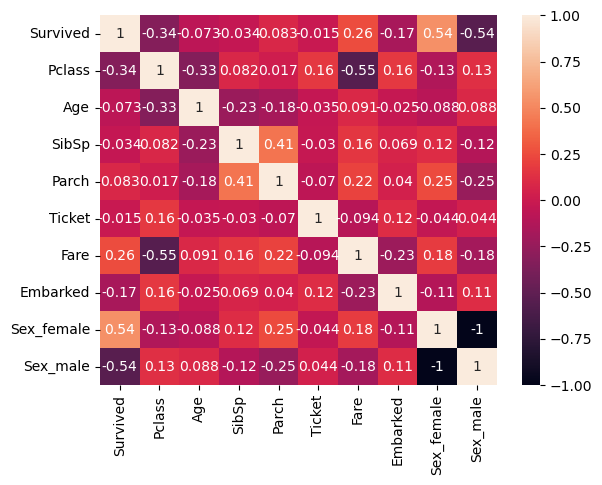

<Figure size 1400x1400 with 0 Axes>

In [43]:
sns.heatmap(correlation,annot=True)
plt.figure(figsize = (14,14))

 #### We do observe : 
 - A strong relationship between those that survived with Pclass though it is negative.
 - There is a stronger relation between age and survivers 
 - There is also a postive relation between the Fare and survivers.
 The above features come in handy in traiing our model.Features with a very low correlation will in this case be elminated or will be feature engineered. 

In [45]:
train_dataset.columns

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Embarked', 'Sex_female', 'Sex_male'],
      dtype='object')

In [97]:
def correlation(df,feature,label):
    '''
    The goal of this function is to produce a correlation between a feature and label ,
    at the end , the goal is to choose which features do have a significant correlation with
    the labels for further ML .
    '''
    return df[[feature,label]].corr()

In [106]:
def determine_if_good_feature(df): 
    '''
    This formular comes in handy in decicing weahter a feature qualifies to be used for further DF
    '''
    if df.iloc[0, 1] >= 0.2 or df.iloc[0, 1] <= -0.2:
        print(f'{df.columns[0]} should not eliminated since its correlation is {df.iloc[0, 1]}')
    else: 
        print(f'{df.columns[0]} should be removed since its correlation is {df.iloc[0, 1]}')

In [112]:
corelation_df = correlation(train_dataset, 'Ticket','Survived') # To enable users to work frely with this ,find a way of survived being default
determine_if_good_feature(corelation_df)

Ticket should be removed since its correlation is -0.015109077895316696


From the above called functions , I have been able to pick out which features can be used for further Data Training : 
These are : **PClass , Sex_male,Sex_female** and **Fare**